# WASP Summer School 2020 
# Gaussian Process Basics Lab 

### Objectives: 
1. Visualize 2D Gaussians and play with mean and covariance parameters
2. Gaussian conditioning
3. Visualize the alternative form of multivariate Gaussians
4. Visualize covariance matrices with various kernels
5. Implement Matern kernels
6. Sample GPs

### Prerequisites: 
In case you didn't go through the prerequisites of this module do it now: [Install](https://github.com/luinardi/hypermapper/wiki/Install-HyperMapper) Anaconda 3.


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from scipy.stats import multivariate_normal
from scipy.stats import norm
import math
import matplotlib.gridspec as gridspec
import seaborn as sns

### #1 Gaussian distribution (5 minutes)
Get familiar with 2D Gaussians. 
* Insert the mean vector and the covariance matrix (covariance needs to be symmetric positive definite)
* Choose a number of samples to show
* Plot
* Repeat (until you get familiar with various $\mathbf{\mu}$ and $\mathbf{\Sigma}$)

In [2]:
def plot_2D_gaussian(mu, Sigma, number_of_samples=0):
    """ Plot a 2D Gaussian defined by mu and Sigma and draw number_of_samples samples from this distribution

        Parameters:
        mu: 2D mean vector
        Sigma: 2x2 covariance matrix
        number_of_samples: number of samples (>=0) to be visualized from a 2D Gaussian defined by mu and Sigma.

        Returns:
        Plots 2D Gaussian
        """

    # Check input parameters
    if len(mu) != 2 or len(Sigma) != 2 or len(Sigma[0]) !=2 or number_of_samples<0 or Sigma[0,1]!=Sigma[1,0]:
        raise SystemExit("Input error.")

    # Set up the multivariate Gaussian
    x1, x2 = np.mgrid[-3:3:.1, -3:3:.1] # 2D distribution over x1 and x2
    pos = np.empty(x1.shape + (2,))     # Pack x1 and x2 into a single 2-dimensional array
    pos[:, :, 0] = x1
    pos[:, :, 1] = x2
    gaussian = multivariate_normal(mu, Sigma)   # Create bivariate Gaussian distribution
    y = gaussian.pdf(pos)                       # Probability density function evaluated on pos
    samples = gaussian.rvs(number_of_samples)   # Sample the multivariate Gausssian pdf

    # Plot
    fig, ax = plt.subplots(figsize=(5, 4.5))
    ax.contourf(x1, x2, y, 10, cmap=cm.YlGnBu)    # Plot bivariate distribution
    ax.plot(samples[:, 0], samples[:, 1], 'ro')   # Plot samples_multivariate

    # Plot formatting
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    ax.axis([-3, 3, -3, 3])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

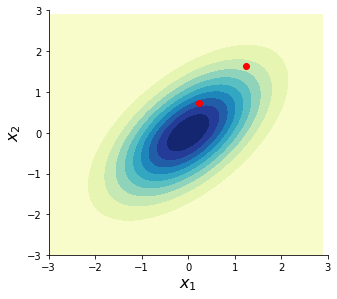

In [3]:
mu = np.array([0., 0.]) # Mean vector. Example: [0., 0.]
Sigma = np.array([      # Covariance matrix. Example: [[1., .4], [.4,  1.]]
    [1., .6],
    [.6,  1.]
])
number_of_samples = 2    # Example: number_of_samples = 10

plot_2D_gaussian(mu, Sigma, number_of_samples)

### #2 Gaussian conditioning (5 minutes)
Get familiar with the conditioning property of Gaussian distributions. 
* Insert the mean vector and the covariance matrix (covariance needs to be symmetric positive definite)
* Insert a conditioning value
* Plot
* Repeat (until you get familiar with Gaussian conditioning)

Remember from the lecture that: 
### $$p({\color{blue}{\mathbf{x_1}}}, {\color{red}{\mathbf{x_2}}}) = \mathcal{N}\begin{pmatrix}\begin{pmatrix} \mathbf{a}\\\mathbf{b} \end{pmatrix}, \begin{pmatrix} \mathbf{A}&\mathbf{B}\\\mathbf{B}^T&\mathbf{C}\end{pmatrix}\end{pmatrix} $$

### $$\Longrightarrow  p({\color{blue}{\mathbf{x_1}}}| {\color{red}{\mathbf{x_2}}}) = \mathcal{N}(\mathbf{a} + \mathbf{BC^{-1}}({\color{red}{\mathbf{x_2}}} - \mathbf{b}), \mathbf{A} - \mathbf{BC^{-1}B^\top}) $$

### $$\Longrightarrow  p({\color{red}{\mathbf{x_2}}}| {\color{blue}{\mathbf{x_1}}}) = \mathcal{N}(\mathbf{b} + \mathbf{B^\top A^{-1}}({\color{blue}{\mathbf{x_1}}} - \mathbf{a}), \mathbf{C} - \mathbf{B^\top A^{-1}B}) $$


In [4]:
def plot_2D_gaussian_conditional_distribution(mu, Sigma, x1_conditioning, number_of_samples=0):
    """ Conditioning of a bivariate Gaussian defined by mu and Sigma.

        Parameters:
        mu: 2D mean vector
        Sigma: 2x2 covariance matrix under the form of
               Sigma = (A   B)
                       (B^T C)
        number_of_samples: number of samples (>=0) to be visualized from the 1D Gaussian defined by mu, Sigma and x1_conditioning.

        Returns:
        Visualization.
    """

    fig = plt.figure(figsize=(8, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
    ax1 = plt.subplot(gs[0]) # Left plot
    sns.set_style('darkgrid')
    ax2 = plt.subplot(gs[1]) # Right plot

    ######### Left plot
    x1, x2 = np.mgrid[-3:3:.1, -3:3:.1]  # 2-dimensional distribution over x1 and x2
    pos = np.empty(x1.shape + (2,))      # Pack x1 and x2 into a single 2-dimensional array
    pos[:, :, 0] = x1
    pos[:, :, 1] = x2
    gaussian = multivariate_normal(mu, Sigma)  # Create bivariate Gaussian distribution
    y = gaussian.pdf(pos)                      # Probability density function evaluated on pos

    con = ax1.contourf(x1, x2, y, 10, cmap=cm.YlGnBu)               # Plot bivariate distribution
    ax1.plot([x1_conditioning, x1_conditioning], [-3, 3], 'b--')    # Conditioning line

    # Plot formatting
    ax1.set_xlabel('$x_1$', fontsize=16)
    ax1.set_ylabel('$x_2$', fontsize=16)
    ax1.axis([-3, 3, -3, 3])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    ######### Right plot
    A = Sigma[0, 0]
    C = Sigma[1, 1]
    B = Sigma[0, 1]
    BT = Sigma[1, 0]
    a = mu[0]
    b = mu[1]
    conditional_mu = b + BT * (1 / A) * (x1_conditioning - a)   # Calculate conditional mu x2|x1
    conditional_sigma = C - (BT * (1 / A) * B)                  # Calculate conditional Sigma x2|x1

    x2x1 = np.linspace(-3, 3, num=100)
    F_univariate = norm(conditional_mu, conditional_sigma)  # Create univariate Gaussian distribution
    px2x1 = F_univariate.pdf(x2x1)                          # Probability density function evaluated on pos
    samples_univariate = F_univariate.rvs(number_of_samples)# Sample the univariate Gausssian pdf

    ax2.plot(px2x1, x2x1, 'b--', label=f'$p(x_2|x_1={x1_conditioning})$') # Plot univariate distribution x2|x1
    ax2.plot(np.zeros(len(samples_univariate)), samples_univariate, 'ro') # Plot samples_univariate

    # Plot formatting
    ax2.legend(loc=0)
    ax2.set_ylim(-3, 3)

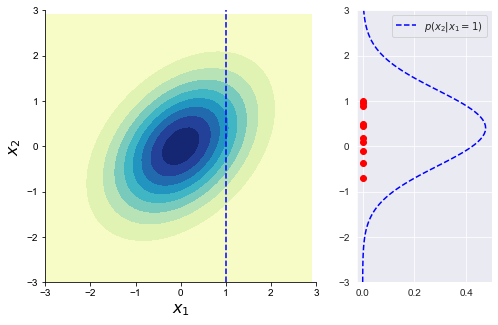

In [5]:
mu = np.array([0., 0.]) # Mean vector
Sigma = np.array([      # Covariance matrix
    [1, .4],
    [.4,  1]
])
x1_conditioning = 1
number_of_samples = 10
plot_2D_gaussian_conditional_distribution(mu, Sigma, x1_conditioning, number_of_samples)

### #3 Visualize Covariance Functions (10 minutes)
Get familiar with various covariance functions and their hyperparameters.
* Pick the parameters
* Plot
* Repeat (until you get familiar with the kernel global properties) 

#### Squared Exponential: $K(x_1, x_2) = \sigma^2 e^{-\frac{1}{2l^2}(x_1 - x_2)^2} $

#### Brownian Motion: $K(x_1, x_2) = \sigma^2 e^{-\frac{1}{2l^2}|x_1 - x_2|} $

#### Periodic: $K(x_1, x_2) = \sigma^2 \cos{(\omega(x_1 - x_2))}e^{-\frac{1}{2l^2}(x_1 - x_2)^2}$



In [6]:
def create_mean_and_covariance(kernel="se", N=10, sigma=1., l=2.5):
    """ Creates a mean vector and a covariance matrix of size NxN for an input space in in [0, 10].
        This method uses the kernel specified by the input parameter "kernel" to generate the covariance matrix.
        Input parameters:
        :param kernel: the kernel used to generate the covariance function. Options are: "se", "bm" and "periodic".
        :param N: number of entries in the covariance matrix NxN.
        :param sigma: the sigma hyperparameter of the kernel.
        :param l: the l hyperparameter of the kernel.

        Returns:
        Mean vector and covariance matrix of size NxN.
    """
    # Check input parameters
    if N < 0 or N > 1000 or sigma < 0. or l < 0.:
        raise SystemExit("Input error.")
        
    input_space = 10.0
    step = input_space/N
    mu = np.zeros(N)
    Sigma = np.zeros((N, N))
    x1 = 0.
    for i in range(N):
        x2 = 0.
        for j in range(N):
            if kernel == "se":
                Sigma[i, j] = (sigma**2.)*math.exp((-1/(2*(l**2)))*(x1-x2)**2)
            elif kernel == "bm":
                Sigma[i, j] = (sigma ** 2.) * math.exp((-1 / (2 * (l ** 2))) * abs(x1 - x2))
            elif kernel == "periodic":
                omega = 1.2
                Sigma[i, j] = (sigma**2.)*math.cos(omega*(x1-x2))*math.exp((-1/(2*(l**2)))*(x1-x2)**2)
            else:
                raise SystemExit("I cannot recognize the kernel requested. Exit.")
            x2 = x2 + step
        x1 = x1 + step
    return(mu, Sigma)

def plot_covariance_matrix(Sigma):
    """     Plot Sigma matrix using colors
            Input parameter:
            :param Sigma: the Sigma covariance matrix to be visualized.

            Returns:
            Plot the covariance matrix. 
    """
    fig, ax = plt.subplots()
    ax.matshow(Sigma, cmap='jet')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

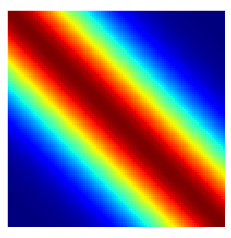

In [7]:
# Pick one of the following kernels: "se", "bm", "periodic"
kernel = "se" 

# Pick vertical and horizontal scale hyperparameters
sigma = 1.
l = 2.5

# Pick the size of the covariance matrix 
# The space is fixed to x=[0, 10] but you can vary the amount of points in that interval (max value is 1000)
number_of_x_points = 100

mu, Sigma = create_mean_and_covariance(kernel, number_of_x_points , sigma, l)
plot_covariance_matrix(Sigma)


### #4 Implement Matern Covariance Functions (10 minutes)
It is possible that the most interesting covariance functions in ML are given by the Matern class of covariance functions (see [Rasmussen and Williams, 2006] Sec. 4.2 for more information) named after Bertil Matérn. Special cases of the Matérn covariance function are the Squared exponential and the Exponential (Ornstein-Uhlenbeck) covariance functions. 

Of particular interest for the ML community are the Matern32 and Matern52 instances that are given by: 

### Matern32: 
## $$\sigma^2 \begin{pmatrix} 1 + \frac{\sqrt{3}|x_1 - x_2|}{l}\end{pmatrix}e^{-\frac{\sqrt{3}|x_1 - x_2|}{l}}$$
 
### Matern52: 
## $$\sigma^2 \begin{pmatrix} 1 + \frac{\sqrt{5}|x_1 - x_2|}{l} + \frac{5(x_1 - x_2)^2}{3l^2}\end{pmatrix}e^{-\frac{\sqrt{5}|x_1 - x_2|}{l}}$$
 


* Implement Matern32 and Matern52 covariance functions in the code above.
* Plot Matern32 and Matern52 multiple times.  
* Vary the hyperparameters of the Matern covariance function. 
* Repeat 
* What do you oberve? How different are they? 



### #5 Alternative Representation of Multi-dimensional Gaussians (10 minutes)
In this section we sample a GP.

* Initialize the vectors for the conditioning. 
* Plot a sample of the GP.
* Execute the same code several times and observe how the plot changes. 
* Repeat (ideas: change the kernel, change the hyperparameters l and sigma, run the Matern kernels).
* What happens to the discrete form of the GP sample when you increase the number of points to 1,000?
* Study the code (ideas: what is the swapping of variables for?).




In [8]:
def conditional(mu, Sigma, x_conditioning):
    """ This is an utility method used in the main method.
        Conditioning of a Gaussian defined by mu and Sigma. 
        This method is more general than the previous one because it works for an arbitrary number of variables. 

        Parameters:
        :param mu: 2D mean vector.
        :param Sigma: 2x2 covariance matrix under the form of.
               Sigma = (XX XY)
                       (YX YY)

        Returns:
        A new mu and Sigma that are the result of the conditioning operation.
    """
    if len(x_conditioning) == 0:
        return(mu, Sigma)

    indices_conditioning = np.array([i for i in range(0, len(x_conditioning))]) # Using list comprehension
    indices_non_conditioning = np.array([i for i in range(len(x_conditioning), len(mu))])

    XX = Sigma[np.ix_(indices_conditioning, indices_conditioning)] # ix_ selects the elements that are the cartesian product of the two arrays in argument
    YY = Sigma[np.ix_(indices_non_conditioning, indices_non_conditioning)]
    XY = Sigma[np.ix_(indices_conditioning, indices_non_conditioning)]
    YX = XY.T

    mu_y = mu[np.ix_(indices_non_conditioning)]
    mu_x = mu[np.ix_(indices_conditioning)]

    conditional_mu = mu_y + np.linalg.inv(XX).dot(YX.T).T.dot(x_conditioning - mu_x)
    conditional_Sigma = YY - YX.dot(np.linalg.inv(XX).dot(XY))
    return (conditional_mu, conditional_Sigma)


def bubble_swap_variables(mu, Sigma, x_conditioning, x_conditioning_indices):
    """ This is an utility method used in the main method.
        It computes the swap of the Gaussian variables (rearrange the variables) in the mu and Sigma matrices so that
        we can condition wrt arbitrary variables.

        Parameters:
        :param mu: mean vector.
        :param Sigma: covariance matrix.
        :param x_conditioning: a list of the conditioning values of the multivariate Gaussian.
        This vector has to have the same size as x_conditioning_indices.
        Example 1, no conditioning: []
        Example 2, conditioning on 3 variables: [1, 1.4, 0.9]

        :param x_conditioning_indices: the x variable indices of the conditioning variables.
        This indicates wrt what Gaussian variables we are conditioning.
        This vector has to have the same size as x_conditioning.
        Example 1, no conditioning: []
        Example 2, conditioning on 3 variables: [5, 12, 35]

        Returns:
        A new mu and Sigma with the conditional variables swapped (moved at the top left corner).
    """

    tmp_Sigma = Sigma.copy()
    tmp_mu = mu.copy()

    if len(x_conditioning) > 0:
        for i in range(len(x_conditioning)):
            j = x_conditioning_indices[i]
            for count in range(j, i, -1):
                # Swapping backward all variables to send the conditional variables to the upper left corner of the
                # covariance matrix, so that we can use the conditioning formula introduced in the slides.
                tmp_Sigma, tmp_mu = swap_variables(tmp_mu, tmp_Sigma, count, count - 1)
    return tmp_mu, tmp_Sigma


def swap_variables(mu, Sigma, i, j):
    """ This is an utility method in the bubble_swap_variables method.
        It computes the swap of two Gaussian variables (rearrange the variables) in the mu and Sigma matrices.
        The method uses the idea of swapping rows and columns to achieve the swap. 
        
        Parameters:
        :param mu: mean vector.
        :param Sigma: covariance matrix.
        :param i: source index.  
        :param j: destination index.
        
        Returns:
        A new mu and Sigma with the i and j variables swapped.
        """
    Sigma[[i, j]] = Sigma[[j, i]]  # Swap rows of Sigma: j -> i and i -> j
    Sigma = Sigma.T
    Sigma[[i, j]] = Sigma[[j, i]]  # Swap columns of Sigma: j -> i and i -> j
    Sigma = Sigma.T
    mu[[i, j]] = mu[[j, i]]  # Swap elements of mu: j -> i and i -> j
    return Sigma, mu


In [9]:
def sample_GP(mu, Sigma, x_conditioning, x_conditioning_indices):
    """ Plot a GP sample.

        Parameters:
        :param mu: mean vector.
        :param Sigma: covariance matrix.
        :param x_conditioning: a list of the conditioning values of the multivariate Gaussian.
        This vector has to have the same size as x_conditioning_indices.
        Example 1, no conditioning: []
        Example 2, conditioning on 3 variables: [1, 1.4, 0.9]

        :param x_conditioning_indices: the x variable indices of the conditioning variables.
        This indicates wrt what Gaussian variables we are conditioning.
        This vector has to have the same size as x_conditioning.
        Example 1, no conditioning: []
        Example 2, conditioning on 3 variables: [5, 12, 35]

        Returns:
        GP sample visualization.
    """

    total_points = len(mu)
    map_to_fixed_x_interval = 10. / total_points

    if len(x_conditioning) != len(x_conditioning_indices):
        raise SystemExit("Error: size of the arrays describing the conditional distributions have to be the same size.")
    for i in range(len(x_conditioning_indices)):
        if x_conditioning_indices[i] >= len(mu):
            raise SystemExit("Conditioning indices out of range. Rewrite your vectors x_conditioning and x_conditioning_indices. ")
            
    # Compute the non-conditioning indices
    x_non_conditioning_indices = np.array([])  # For the conditional distribution variable indices
    for i in range(len(mu)):
        if i not in x_conditioning_indices:
            x_non_conditioning_indices = np.append(x_non_conditioning_indices, i)

    tmp_mu, tmp_Sigma = bubble_swap_variables(mu, Sigma, x_conditioning, x_conditioning_indices)  # Arrange variables to be able to compute the conditional Gaussian
    mu_conditional, Sigma_conditional = conditional(tmp_mu, tmp_Sigma, x_conditioning)            # Compute conditional Gaussian

    F_multivariate = multivariate_normal(mu_conditional, Sigma_conditional, allow_singular=True) # Create multivariate Gaussian distribution on the conditional mu and Sigma
    # Sample the multivariate Gausssian, i.e., sample the Gaussian process
    if len(mu_conditional) == 1:
        sample = [F_multivariate.rvs(1)]
    else:
        sample = F_multivariate.rvs(1)

    # This block plots the new visualization with two points connected by a bar
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(x_conditioning_indices * map_to_fixed_x_interval, x_conditioning, 'rx', markeredgewidth=4, ms=10) # Plot conditioning points
    ax.plot(x_non_conditioning_indices * map_to_fixed_x_interval, sample, 'ko', ms=2)  # Plot samples_multivariate

    # Plot formatting
    ax.set_xlabel('$x$', fontsize=30)
    ax.set_ylabel('$y$', fontsize=30)
    ax.axis([-1, 11, -3, 3])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()


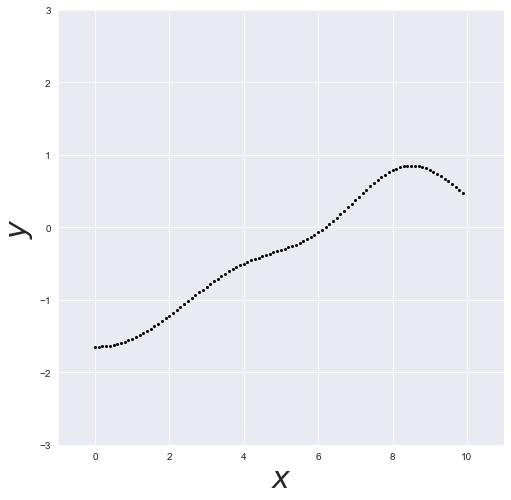

In [10]:
number_of_x_points = 100              # Pick the number of points on the x axis (this corresponds to the size of your covariance matrix). The space is fixed to x=[0, 10] but you can vary the amount of points in that interval
x_conditioning = np.array([])         # For the conditional distribution
x_conditioning_indices = np.array([]) # For the conditional distribution variable indices

# Example 2: 
# number_of_x_points = 10
# x_conditioning = np.array([])         # For the conditional distribution
# x_conditioning_indices = np.array([]) # For the conditional distribution variable indices

# Example 3: 
# number_of_x_points = 1000
# x_conditioning = np.array([0.5])         # For the conditional distribution
# x_conditioning_indices = np.array([10])  # For the conditional distribution variable indices. The values have to be <= than number_of_x_points

# Example 4: 
# number_of_x_points = 100
# x_conditioning = np.array([1., 1.4, 0.5, 1.])          # For the conditional distribution
# x_conditioning_indices = np.array([10, 15, 60, 70]) # For the conditional distribution variable indices

# Example 5: 
# number_of_x_points = 1000
# x_conditioning = np.array([1., 1.4, 0.5, 1.])          # For the conditional distribution
# x_conditioning_indices = np.array([10, 150, 600, 700]) # For the conditional distribution variable indices

mu, Sigma = create_mean_and_covariance("se", number_of_x_points)
sample_GP(mu, Sigma, x_conditioning, x_conditioning_indices)


### #6 Plot GP Regression (5 minutes)
In this section we plot the GP regression. 

* Initialize the vectors for the conditioning. 
* Plot.
* Repeat (ideas: change the kernel, change the hyperparameters l and sigma, run the Matern kernels).
* Study the code.



In [11]:
def plot_GP_mean_and_std(mu, Sigma, x_conditioning, x_conditioning_indices):
    """ Plot the GP mean and 2 Sigma.

                    Parameters:
                    :param mu: mean vector.
                    :param Sigma: covariance matrix.
                    :param x_conditioning: a list of the conditioning values of the multivariate Gaussian.
                    This vector has to have the same size as x_conditioning_indices.
                    Example 1, no conditioning: []
                    Example 2, conditioning on 3 variables: [1, 1.4, 0.9]

                    :param x_conditioning_indices: the x variable indices of the conditioning variables.
                    This indicates wrt what Gaussian variables we are conditioning.
                    This vector has to have the same size as x_conditioning.
                    Example 1, no conditioning: []
                    Example 2, conditioning on 3 variables: [5, 12, 35]

                    Returns:
                    GP visualization.
            """

    if len(x_conditioning) != len(x_conditioning_indices):
        raise SystemExit("Error: size of the arrays describing the conditional distributions have to be the same size.")
    for i in range(len(x_conditioning_indices)):
        if x_conditioning_indices[i] >= len(mu):
            raise SystemExit("Conditioning indices out of range. Rewrite your vectors x_conditioning and x_conditioning_indices. ")

    total_points = len(mu)
    map_to_fixed_x_interval = 10. / total_points

    tmp_mu, tmp_Sigma = bubble_swap_variables(mu, Sigma, x_conditioning, x_conditioning_indices) # Arrange variables to be able to compute the conditional Gaussian
    mu_conditional, Sigma_conditional = conditional(tmp_mu, tmp_Sigma, x_conditioning) # Compute conditional Gaussian

    all_indices_x = np.zeros(len(mu))
    all_indices_2_sigma_upper_bound_x = np.zeros(len(mu))
    all_indices_2_sigma_lower_bound_x = np.zeros(len(mu))
    all_indices_y = np.zeros(len(mu))
    xi_conditioning = 0
    xi_sample = 0
    xi = 0.
    step = 10. / total_points  # The x axis is in the interval of [0, 10]
    for i in range(0, total_points, 1):
        all_indices_x[i] = xi
        if i in x_conditioning_indices:
            all_indices_y[i] = x_conditioning[xi_conditioning]
            all_indices_2_sigma_upper_bound_x[i] = all_indices_y[i]
            all_indices_2_sigma_lower_bound_x[i] = all_indices_y[i]
            xi_conditioning = xi_conditioning + 1
        else:
            all_indices_y[i] = mu_conditional[xi_sample]
            all_indices_2_sigma_upper_bound_x[i] = all_indices_y[i] + 2*Sigma_conditional[xi_sample, xi_sample]
            all_indices_2_sigma_lower_bound_x[i] = all_indices_y[i] - 2*Sigma_conditional[xi_sample, xi_sample]
            xi_sample = xi_sample + 1
        xi = xi + step

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(x_conditioning_indices * map_to_fixed_x_interval, x_conditioning, 'rx', markeredgewidth=4, ms=10)  # Plot conditioning points
    ax.plot(all_indices_x, all_indices_y, 'b', alpha=.6, linewidth=1)  # Plot mean
    plt.fill_between(all_indices_x, all_indices_2_sigma_lower_bound_x, all_indices_2_sigma_upper_bound_x, color="#CCCCFB") # Plot 2 sigma

    # Plot formatting
    ax.set_xlabel('$x$', fontsize=30)
    ax.set_ylabel('$y$', fontsize=30)
    ax.axis([-1, 10, -3, 3])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()


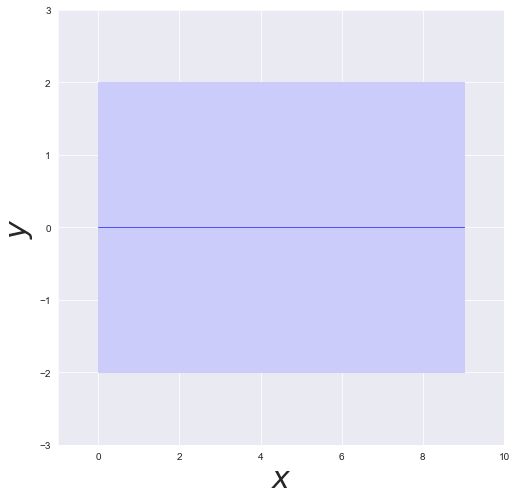

In [12]:
number_of_x_points = 10               # Pick the number of points on the x axis (this corresponds to the size of your covariance matrix). The space is fixed to x=[0, 10] but you can vary the amount of points in that interval
x_conditioning = np.array([])         # For the conditional distribution
x_conditioning_indices = np.array([]) # For the conditional distribution variable indices

# Example 2: 
# number_of_x_points = 100
# x_conditioning = np.array([0.5])         # For the conditional distribution
# x_conditioning_indices = np.array([10])  # For the conditional distribution variable indices. The values have to be <= than number_of_x_points

# Example 3: 
# number_of_x_points = 1000
# x_conditioning = np.array([1., 1.4, 0.5, 1.])           # For the conditional distribution
# x_conditioning_indices = np.array([10, 150, 600, 700])  # For the conditional distribution variable indices

mu, Sigma = create_mean_and_covariance("se", number_of_x_points)
plot_GP_mean_and_std(mu, Sigma, x_conditioning, x_conditioning_indices)
